In [ ]:
!unzip Data.zip

Archive:  Data.zip
   creating: Data/
   creating: Data/input/
  inflating: Data/input/1.jpg        
  inflating: Data/input/10.jpeg      
  inflating: Data/input/11.avif      
  inflating: Data/input/12.jpg       
  inflating: Data/input/13.jpeg      
  inflating: Data/input/14.jpeg      
  inflating: Data/input/2.jpeg       
  inflating: Data/input/3.jpg        
  inflating: Data/input/4.jpg        
  inflating: Data/input/8.jpeg       
  inflating: Data/input/9.jpg        
   creating: Data/output/
  inflating: Data/output/1.jpg       
  inflating: Data/output/10.jpg      
  inflating: Data/output/11.jpg      
  inflating: Data/output/12.jpg      
  inflating: Data/output/13.jpg      
  inflating: Data/output/14.jpg      
  inflating: Data/output/15.jpg      
  inflating: Data/output/16.jpg      
  inflating: Data/output/17.jpg      
  inflating: Data/output/18.jpg      
  inflating: Data/output/19.jpg      
  inflating: Data/output/2.jpeg      
  inflating: Data/output/2.jpg       

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.6/871.6 kB 49.8 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

In [ ]:
model_pose = YOLO("./models/yolov8m-pose.pt")
model_detect = YOLO("./models/yolov8s.pt")
model_seg = YOLO("./models/yolov8x-seg.pt")

100%|██████████| 50.8M/50.8M [00:01<00:00, 39.5MB/s]


100%|██████████| 21.5M/21.5M [00:00<00:00, 488MB/s]


100%|██████████| 137M/137M [00:04<00:00, 35.0MB/s]


In [ ]:
input_dir = "./Data/input"
pre_processed_output = "./Data/processed"
segmented_output = "./Data/seg"

In [ ]:
extensions=['.jpg', '.jpeg', '.png', '.bmp', '.tiff']

In [ ]:
import os
from PIL import Image
import numpy as np
from ultralytics import YOLO

def preprocess_image(input_dir, output_dir):
    processed_files_count = 0
    successful_crops_count = 0
    op_without_detection = 0

    for filename in os.listdir(input_dir):
        if any(filename.lower().endswith(ext) for ext in extensions):
            image_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)
            processed_files_count += 1
            print(image_path)
            raw_image = Image.open(image_path)

            # Run YOLOv8 on the image
            results = model_detect(image_path)

            person_detected = False

            for result in results:
                boxes = result.boxes  # Bounding boxes
                names = result.names  # Detected class names

                for box in boxes:
                    # Get the class label index
                    class_id = int(box.cls[0])
                    class_name = names[class_id]

                    if class_name == 'person':
                        # Extract the bounding box coordinates
                        min_x, min_y, max_x, max_y = box.xyxy[0].tolist()

                        img_array = np.array(raw_image)

                        cropped_image = img_array[int(min_y):int(max_y), int(min_x):int(max_x)]

                        # Ensure the cropped image is not empty
                        if cropped_image.size > 0:
                            img = Image.fromarray(cropped_image)
                            img.save(output_path, 'JPEG')
                            successful_crops_count += 1
                            person_detected = True
                        break  # We only need to crop for the first person detected

                if not person_detected:
                    print(f"No person detected in image: {filename}")
                    op_without_detection += 1

    print(f"Total processed files: {processed_files_count}")
    print(f"Total successful crops: {successful_crops_count}")
    print(f"Images without person detection: {op_without_detection}")



In [ ]:
preprocess_image(input_dir,pre_processed_output)

./Data/input/12.jpg

image 1/1 /content/Data/input/12.jpg: 640x448 1 person, 42.3ms
Speed: 12.7ms preprocess, 42.3ms inference, 1008.3ms postprocess per image at shape (1, 3, 640, 448)
./Data/input/4.jpg

image 1/1 /content/Data/input/4.jpg: 640x416 1 person, 71.6ms
Speed: 5.3ms preprocess, 71.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)
./Data/input/14.jpeg

image 1/1 /content/Data/input/14.jpeg: 640x512 1 person, 68.8ms
Speed: 6.3ms preprocess, 68.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)
./Data/input/10.jpeg

image 1/1 /content/Data/input/10.jpeg: 640x448 1 person, 12.9ms
Speed: 3.0ms preprocess, 12.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)
./Data/input/2.jpeg

image 1/1 /content/Data/input/2.jpeg: 640x512 1 person, 13.1ms
Speed: 3.6ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)
./Data/input/13.jpeg

image 1/1 /content/Data/input/13.jpeg: 640x448 1 person, 16.0ms
Spe

In [ ]:
import os
from PIL import Image
import numpy as np
from ultralytics import YOLO

def segment_image(input_dir, output_dir):
    processed_files_count = 0
    successful_crops_count = 0
    op_without_detection = 0

    for filename in os.listdir(input_dir):
        if any(filename.lower().endswith(ext) for ext in extensions):
            image_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)
            processed_files_count += 1
            print(f"Processing: {image_path}")
            raw_image = Image.open(image_path)
            img_array = np.array(raw_image)

            # Run YOLOv8 segmentation on the image
            results = model_seg(image_path)
            person_detected = False

            for result in results:
                # Get segmentation masks and class IDs
                masks = result.masks  # Segmentation masks
                class_ids = result.boxes.cls  # Class IDs for detected objects
                names = result.names  # Detected class names

                for mask, class_id in zip(masks.data, class_ids):
                    class_name = names[int(class_id)]

                    # Check if the detected class is 'person'
                    if class_name == 'person':
                        mask_np = mask.cpu().numpy()  # Convert the mask to NumPy array

                        # Resize the original image to match the mask size
                        mask_height, mask_width = mask_np.shape
                        img_resized = np.array(raw_image.resize((mask_width, mask_height)))

                        # Create a white background of the same size as the resized image
                        white_background = np.ones_like(img_resized) * 255

                        # Apply the mask to replace the background with white
                        segmented_image = np.where(mask_np[..., None], img_resized, white_background)

                        # Convert the result back to an image
                        img_segmented = Image.fromarray(segmented_image.astype(np.uint8))

                        # Save the resulting image
                        img_segmented.save(output_path, 'JPEG')
                        successful_crops_count += 1
                        person_detected = True
                        break  # Stop once a person is detected and processed

            if not person_detected:
                print(f"No person detected in image: {filename}")
                op_without_detection += 1

    print(f"Total processed files: {processed_files_count}")
    print(f"Total successful crops: {successful_crops_count}")
    print(f"Images without person detection: {op_without_detection}")

In [ ]:
segment_image(pre_processed_output,segmented_output)

Processing: ./Data/processed/12.jpg

image 1/1 /content/Data/processed/12.jpg: 640x288 1 person, 70.2ms
Speed: 1.5ms preprocess, 70.2ms inference, 15.2ms postprocess per image at shape (1, 3, 640, 288)
Processing: ./Data/processed/4.jpg

image 1/1 /content/Data/processed/4.jpg: 640x256 1 person, 59.5ms
Speed: 5.0ms preprocess, 59.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)
Processing: ./Data/processed/14.jpeg

image 1/1 /content/Data/processed/14.jpeg: 640x224 1 person, 51.3ms
Speed: 1.7ms preprocess, 51.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 224)
Processing: ./Data/processed/10.jpeg

image 1/1 /content/Data/processed/10.jpeg: 640x288 1 person, 36.8ms
Speed: 1.7ms preprocess, 36.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 288)
Processing: ./Data/processed/2.jpeg

image 1/1 /content/Data/processed/2.jpeg: 640x224 1 person, 29.2ms
Speed: 1.1ms preprocess, 29.2ms inference, 2.1ms postprocess per image at shape (1, 3, 64

In [ ]:
!pip install ninja

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 22.5 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/PeikeLi/Self-Correction-Human-Parsing
%cd Self-Correction-Human-Parsing

fatal: destination path 'Self-Correction-Human-Parsing' already exists and is not an empty directory.
/content/Self-Correction-Human-Parsing


In [ ]:
dataset = 'pascal'         #select from ['lip', 'atr', 'pascal']

In [ ]:
!mkdir checkpoints
!mkdir ../Data/parse


mkdir: cannot create directory ‘checkpoints’: File exists
mkdir: cannot create directory ‘../Data/parse_lip’: File exists


In [ ]:
import gdown

if dataset == 'lip':
    url = 'https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH'
elif dataset == 'atr':
    url = 'https://drive.google.com/uc?id=1ruJg4lqR_jgQPj-9K0PP-L2vJERYOxLP'
elif dataset == 'pascal':
    url = 'https://drive.google.com/uc?id=1E5YwNKW2VOEayK9mWCS3Kpsxf-3z04ZE'

output = 'checkpoints/final.pth'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1E5YwNKW2VOEayK9mWCS3Kpsxf-3z04ZE
From (redirected): https://drive.google.com/uc?id=1E5YwNKW2VOEayK9mWCS3Kpsxf-3z04ZE&confirm=t&uuid=aa604f85-b0b4-488c-a0fc-aea458d4eac6
To: /content/Self-Correction-Human-Parsing/checkpoints/final.pth
100%|██████████| 267M/267M [00:03<00:00, 76.7MB/s]


'checkpoints/final.pth'

In [ ]:
!python3 simple_extractor.py --dataset 'pascal' --model-restore 'checkpoints/final.pth' --input-dir '../Data/seg' --output-dir '../Data/parse'

/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Evaluating total class number 7 with ['Background', 'Head', 'Torso', 'Upper Arms', 'Lower Arms', 'Upper Legs', 'Lower Legs']
/content/Self-Correction-Human-Parsing/simple_extractor.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed 

In [ ]:
%cd /content/

/content


In [ ]:
parse_path = "./Data/parse"

In [ ]:
import os

for file in os.listdir(parse_path):
    if any(file.lower().endswith(ext) for ext in extensions):
        name, ext = os.path.splitext(file)

        # Remove extra dots
        corrected_name = name.replace('.', '')
        # Construct the new file name
        new_file_name = corrected_name + ext
        # Get full file paths
        old_file_path = os.path.join(parse_path, file)
        new_file_path = os.path.join(parse_path, new_file_name)

        # Rename the file
        os.rename(old_file_path, new_file_path)
        print(f'Renamed: {file} -> {new_file_name}')

Renamed: 9.png -> 9.png
Renamed: 10.png -> 10.png
Renamed: 14.png -> 14.png
Renamed: 8..png -> 8.png
Renamed: 2.png -> 2.png
Renamed: 10..png -> 10.png
Renamed: 12.png -> 12.png
Renamed: 13.png -> 13.png
Renamed: 3.png -> 3.png
Renamed: 8.png -> 8.png
Renamed: 13..png -> 13.png
Renamed: 14..png -> 14.png
Renamed: 1.png -> 1.png
Renamed: 2..png -> 2.png
Renamed: 4.png -> 4.png


YOLOv8 pose models use the -pose suffix, i.e. yolov8n-pose.pt. These models are trained on the COCO keypoints dataset and are suitable for a variety of pose estimation tasks.

In the default YOLOv8 pose model, there are 17 keypoints, each representing a different part of the human body. Here is the mapping of each index to its respective body joint:

0: Nose 1: Left Eye 2: Right Eye 3: Left Ear 4: Right Ear 5: Left Shoulder 6: Right Shoulder 7: Left Elbow 8: Right Elbow 9: Left Wrist 10: Right Wrist 11: Left Hip 12: Right Hip 13: Left Knee 14: Right Knee 15: Left Ankle 16: Right Ankle

In [ ]:
dataset_settings = {
    'lip': {
        'input_size': [473, 473],
        'num_classes': 20,
        'label': ['Background', 'Hat', 'Hair', 'Glove', 'Sunglasses', 'Upper-clothes', 'Dress', 'Coat',
                  'Socks', 'Pants', 'Jumpsuits', 'Scarf', 'Skirt', 'Face', 'Left-arm', 'Right-arm',
                  'Left-leg', 'Right-leg', 'Left-shoe', 'Right-shoe']
    },
    'atr': {
        'input_size': [512, 512],
        'num_classes': 18,
        'label': ['Background', 'Hat', 'Hair', 'Sunglasses', 'Upper-clothes', 'Skirt', 'Pants', 'Dress', 'Belt',
                  'Left-shoe', 'Right-shoe', 'Face', 'Left-leg', 'Right-leg', 'Left-arm', 'Right-arm', 'Bag', 'Scarf']
    },
    'pascal': {
        'input_size': [512, 512],
        'num_classes': 7,
        'label': ['Background', 'Head', 'Torso', 'Upper Arms', 'Lower Arms', 'Upper Legs', 'Lower Legs'],
    }
}

def get_palette(num_cls):
    """ Returns the color map for visualizing the segmentation mask.
    Args:
        num_cls: Number of classes
    Returns:
        The color map
    """
    n = num_cls
    palette = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab:
            palette[j * 3 + 0] |= (((lab >> 0) & 1) << (7 - i))
            palette[j * 3 + 1] |= (((lab >> 1) & 1) << (7 - i))
            palette[j * 3 + 2] |= (((lab >> 2) & 1) << (7 - i))
            i += 1
            lab >>= 3
    return palette

def generate_color_to_label_mapping(dataset_settings, dataset_type):
    labels = dataset_settings[dataset_type]['label']
    num_classes = dataset_settings[dataset_type]['num_classes']

    # Generate the color palette
    palette = get_palette(num_classes)

    # Initialize the color_to_label dictionary
    color_to_label = {}

    # Map each color in the palette to the corresponding label
    for i, label in enumerate(labels):
        # Convert the color from RGB to BGR
        color = (palette[3 * i + 2], palette[3 * i + 1], palette[3 * i])
        color_to_label[color] = label

    return color_to_label

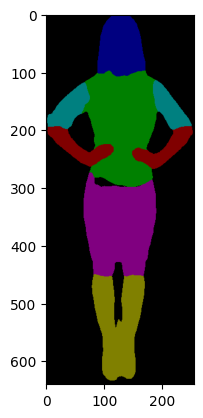

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
def map_colors_to_labels(human_parse_image, dataset_type, dataset_settings):
    """
    Maps the colors of the human parse output to the corresponding labels.

    Args:
        human_parse_image: The segmentation image output where each pixel has a specific color.
        dataset_type: The dataset type (e.g., 'lip', 'pascal', 'atr').
        dataset_settings: The settings dictionary containing label information and input size for each dataset.

    Returns:
        A 2D array where each value is the label corresponding to the pixel.
    """
    # Get the label names and the number of classes for the dataset type
    labels = dataset_settings[dataset_type]['label']
    num_classes = dataset_settings[dataset_type]['num_classes']

    # Generate the color palette for the given dataset
    color_to_label = generate_color_to_label_mapping(dataset_settings,dataset_type)

    # Get the dimensions of the image (height, width)
    height, width, _ = human_parse_image.shape

    # Create an empty label map to store the class label for each pixel
    label_map = np.zeros((height, width), dtype=np.int32)

    # Iterate over each pixel in the human_parse_image
    for i in range(height):
        for j in range(width):
            # Get the color of the pixel (BGR format from OpenCV)
            color = tuple(human_parse_image[i, j])  # (B, G, R)

            # Find the corresponding label from the color_to_label dictionary
            if color in color_to_label:
                label_map[i, j] = labels.index(color_to_label[color])
            else:
                label_map[i, j] = 0  # Set to 'Background' if color is not found

    return label_map

# Example usage:
# Assuming you have:
# - human_parse_image: The segmentation image output (in BGR format, loaded using OpenCV)
# - dataset_type: The dataset type, e.g., 'lip', 'pascal', or 'atr'

human_parse_image = '/content/Data/parse/9.png'
human_parse_image = cv2.imread(human_parse_image)
plt.imshow(human_parse_image)
dataset_type = 'pascal'  # Choose the dataset type you're working with

# Get the pixel-to-label mapping
label_map = map_colors_to_labels(human_parse_image, dataset_type, dataset_settings)
# print(label_map)
# Now you have a 2D label_map where each pixel has a label corresponding to its class


class label: Head, class index: 1
class label: Torso, class index: 2
class label: Upper Arms, class index: 3
class label: Lower Arms, class index: 4
class label: Upper Legs, class index: 5
class label: Lower Legs, class index: 6


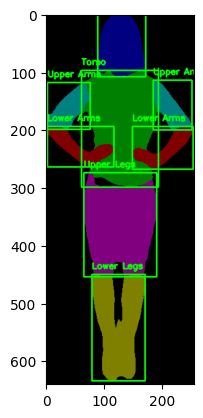

In [ ]:
import cv2
import numpy as np

def draw_bounding_boxes(human_parse_image, dataset_type, dataset_settings):
    """
    Draws bounding boxes around the regions in the human parse image based on their class.

    Args:
        human_parse_image: The segmentation image output where each pixel has a specific color.
        dataset_type: The dataset type (e.g., 'lip', 'pascal', 'atr').
        dataset_settings: The settings dictionary containing label information and input size for each dataset.

    Returns:
        Image with bounding boxes drawn around different regions and a dictionary of bounding boxes for specific classes.
    """
    label_map = map_colors_to_labels(human_parse_image, dataset_type, dataset_settings)
    labels = dataset_settings[dataset_type]['label']
    output_image = human_parse_image.copy()

    # Dictionary to store bounding boxes
    bounding_boxes = {}

    for class_idx in range(1, len(labels)):  # Starting from 1 to exclude 'Background'
        class_label = labels[class_idx]
        print(f"class label: {class_label}, class index: {class_idx}")
        mask = np.uint8(label_map == class_idx)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            if cv2.contourArea(contour) > 100:
                x, y, w, h = cv2.boundingRect(contour)
                cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(output_image, class_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                # Store bounding box in dictionary
                if class_label not in bounding_boxes:
                    bounding_boxes[class_label] = []
                bounding_boxes[class_label].append((x, y, w, h))

    return output_image, bounding_boxes


# Example usage:
# Assuming you have:
# - human_parse_image: The segmentation image output (in BGR format, loaded using OpenCV)
# - dataset_type: The dataset type, e.g., 'lip', 'pascal', or 'atr'

human_parse_image = '/content/Data/parse/9.png'
human_parse_image = cv2.imread(human_parse_image)
dataset_type = 'pascal'  # Choose the dataset type you're working with

# Draw bounding boxes on the image
output_image_with_boxes, bb = draw_bounding_boxes(human_parse_image, dataset_type, dataset_settings)

# Display the image with bounding boxes
plt.imshow(output_image_with_boxes)
plt.show()

YOLOv8 pose models use the -pose suffix, i.e. yolov8n-pose.pt. These models are trained on the COCO keypoints dataset and are suitable for a variety of pose estimation tasks.

In the default YOLOv8 pose model, there are 17 keypoints, each representing a different part of the human body. Here is the mapping of each index to its respective body joint:

0: Nose 1: Left Eye 2: Right Eye 3: Left Ear 4: Right Ear 5: Left Shoulder 6: Right Shoulder 7: Left Elbow 8: Right Elbow 9: Left Wrist 10: Right Wrist 11: Left Hip 12: Right Hip 13: Left Knee 14: Right Knee 15: Left Ankle 16: Right Ankle

In [ ]:
import os
import numpy as np
from PIL import Image, ImageDraw
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Function to find the extent of the hip region
def find_extent(image_array, parse_array, hip_x, hip_y, class_idx):
    height, width, _ = image_array.shape
    dataset_type = 'pascal'

    label_map = map_colors_to_labels(parse_array, dataset_type, dataset_settings)
    labels = dataset_settings[dataset_type]['label']
    # class_idx = 5 #index of upper-legs
    if isinstance(class_idx, list):
        class_label = []
        for idx in class_idx:
            class_label.append(labels[idx])

    mask = np.uint8(np.isin(label_map, class_idx))

    # Initialize bounds
    left_bound = hip_x
    right_bound = hip_x
    conf = 0
    # Extend left from the hip position
    if(parse_array is not None and label_map[hip_y,hip_x] in class_idx):
      conf = 1
      for x in range(hip_x, -1, -1):
          if label_map[hip_y, x] in class_idx and np.any(image_array[hip_y, x] != [255, 255, 255]):  # Check if pixel belongs to 'upper-legs'
              left_bound = x
          else:
              break
      for x in range(hip_x, width):
          if label_map[hip_y, x] in class_idx and np.any(image_array[hip_y, x] != [255, 255, 255]):  # Check if pixel is not white
              right_bound = x
          else:
              break
    else:
        for x in range(hip_x, -1, -1):
            if np.any(image_array[hip_y, x] != [255, 255, 255]):  # Check if pixel is not white
                left_bound = x
            else:
                break
        for x in range(hip_x, width):
            if np.any(image_array[hip_y, x] != [255, 255, 255]):  # Check if pixel is not white
                right_bound = x
            else:
                break
    # print(label_map[hip_y,hip_x])
    return left_bound, right_bound, conf
    # # Extract the row at hip_y
    # if(parse_array is not None and label_map[hip_y, hip_x] == class_idx):
    #     # Find the leftmost and rightmost positions of the class_idx
    #     for x in range(width):
    #         if label_map[hip_y, x] == class_idx:
    #             if left_bound is None:
    #                 left_bound = x
    #             right_bound = x

    #     # Handle cases where class_idx is not found
    #     if left_bound is not None and right_bound is not None:
    #         return left_bound, right_bound




image 1/1 /content/Data/seg/12.jpg: 640x288 1 person, 24.4ms
Speed: 1.2ms preprocess, 24.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)
(640, 288, 3)
Image: 12.jpg
Hip Width at y=287: 125.00 pixels
Shoulder Width at y=113: 110.00 pixels
Waist Width at y=229: 97.00 pixels
Bust Width at y=156: 110.00 pixels


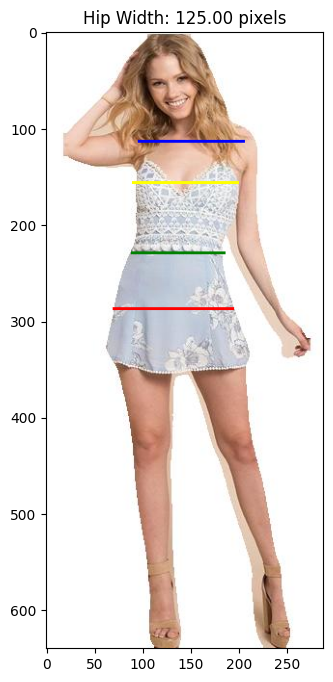


image 1/1 /content/Data/seg/4.jpg: 640x256 1 person, 20.7ms
Speed: 1.1ms preprocess, 20.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)
(640, 256, 3)
Image: 4.jpg
Hip Width at y=303: 191.00 pixels
Shoulder Width at y=123: 137.00 pixels
Waist Width at y=243: 208.00 pixels
Bust Width at y=168: 147.00 pixels


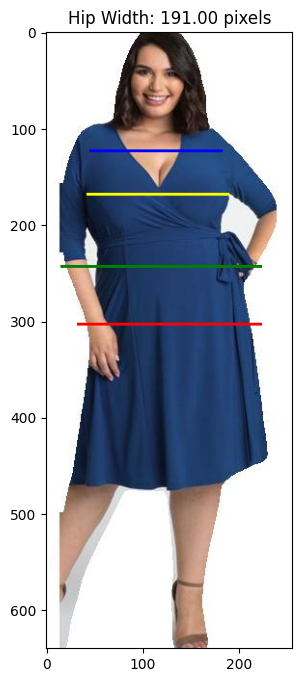


image 1/1 /content/Data/seg/14.jpeg: 640x224 1 person, 23.1ms
Speed: 1.3ms preprocess, 23.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 224)
(640, 224, 3)
Image: 14.jpeg
Hip Width at y=297: 145.00 pixels
Shoulder Width at y=122: 124.00 pixels
Waist Width at y=238: 141.00 pixels
Bust Width at y=165: 134.00 pixels


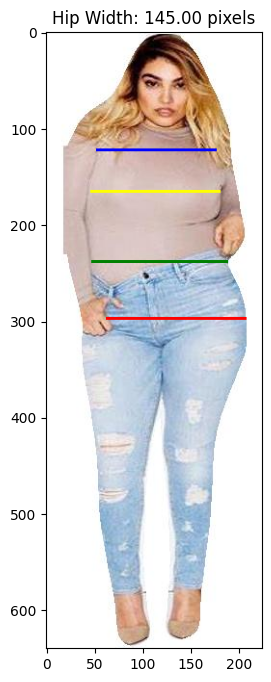


image 1/1 /content/Data/seg/10.jpeg: 640x288 1 person, 25.9ms
Speed: 1.3ms preprocess, 25.9ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 288)
(640, 288, 3)
Image: 10.jpeg
Hip Width at y=306: 125.00 pixels
Shoulder Width at y=130: 124.00 pixels
Waist Width at y=247: 59.00 pixels
Bust Width at y=174: 152.00 pixels


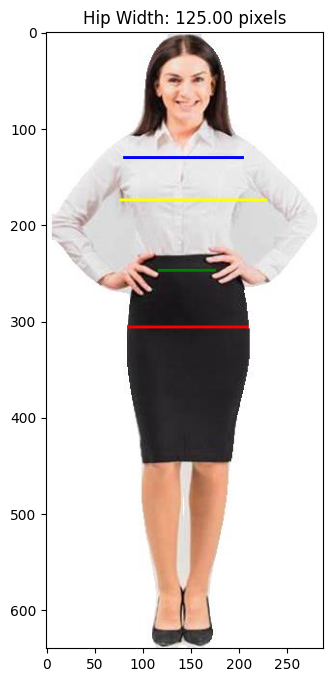


image 1/1 /content/Data/seg/2.jpeg: 640x224 1 person, 20.5ms
Speed: 1.1ms preprocess, 20.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 224)
(640, 224, 3)
Image: 2.jpeg
Hip Width at y=310: 154.00 pixels
Shoulder Width at y=137: 84.00 pixels
Waist Width at y=252: 108.00 pixels
Bust Width at y=180: 145.00 pixels


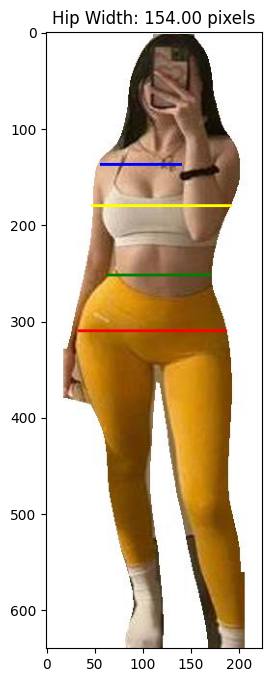


image 1/1 /content/Data/seg/13.jpeg: 640x224 1 person, 19.9ms
Speed: 1.1ms preprocess, 19.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 224)
(640, 224, 3)
Image: 13.jpeg
Hip Width at y=286: 146.00 pixels
Shoulder Width at y=122: 98.00 pixels
Waist Width at y=231: 77.00 pixels
Bust Width at y=163: 100.00 pixels


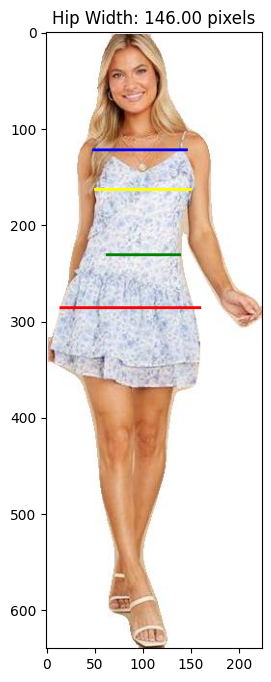


image 1/1 /content/Data/seg/9.jpg: 640x256 1 person, 20.8ms
Speed: 1.3ms preprocess, 20.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)
(640, 256, 3)
Image: 9.jpg
Hip Width at y=303: 119.00 pixels
Shoulder Width at y=128: 160.00 pixels
Waist Width at y=244: 185.00 pixels
Bust Width at y=171: 118.00 pixels


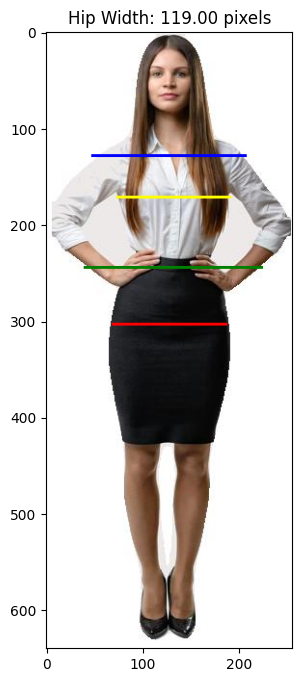


image 1/1 /content/Data/seg/8.jpeg: 640x224 1 person, 20.2ms
Speed: 1.3ms preprocess, 20.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 224)
(640, 224, 3)
Image: 8.jpeg
Hip Width at y=302: 163.00 pixels
Shoulder Width at y=131: 122.00 pixels
Waist Width at y=245: 118.00 pixels
Bust Width at y=173: 126.00 pixels


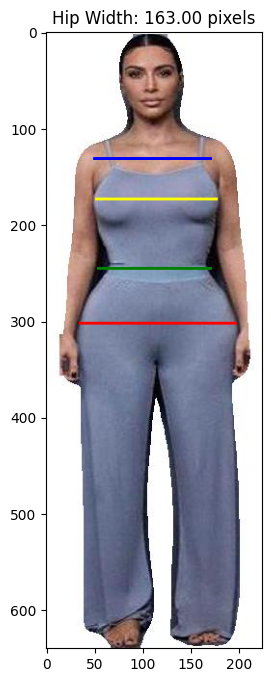


image 1/1 /content/Data/seg/1.jpg: 640x256 1 person, 23.5ms
Speed: 1.2ms preprocess, 23.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)
(640, 256, 3)
Image: 1.jpg
Hip Width at y=312: 153.00 pixels
Shoulder Width at y=134: 119.00 pixels
Waist Width at y=252: 116.00 pixels
Bust Width at y=178: 125.00 pixels


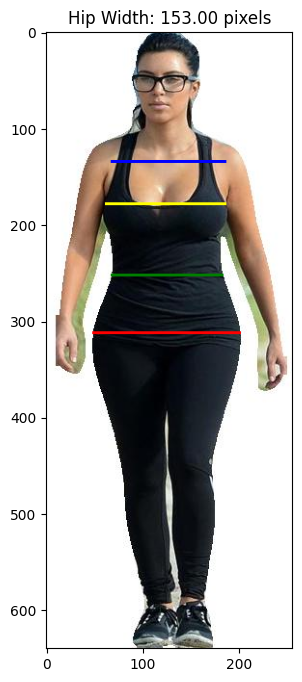


image 1/1 /content/Data/seg/3.jpg: 640x256 1 person, 19.3ms
Speed: 1.1ms preprocess, 19.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)
(640, 256, 3)
Image: 3.jpg
Hip Width at y=301: 185.00 pixels
Shoulder Width at y=123: 113.00 pixels
Waist Width at y=241: 142.00 pixels
Bust Width at y=167: 128.00 pixels


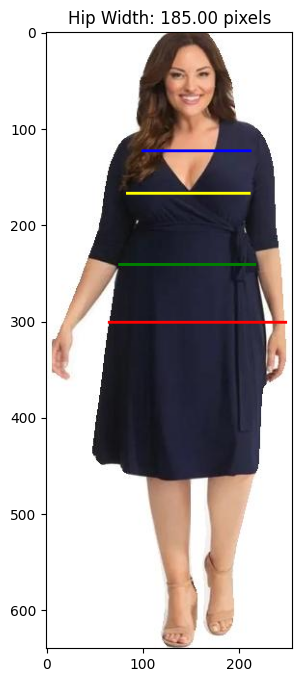

In [ ]:
import pandas as pd

# List to store the results
data = []

# Define folders
folder_path = segmented_output
op_path = "./Model_output"
extensions = ['jpg', 'jpeg', 'png']  # Assuming these are the image file extensions

for file in os.listdir(folder_path):
    if any(file.lower().endswith(ext) for ext in extensions):
        image_path = os.path.join(folder_path, file)
        # Replace the file extension with .png
        parse_filename = os.path.splitext(file)[0] + '.png'
        parse = os.path.join(parse_path, parse_filename)
        results = model_pose(image_path)

        for result in results:
            keypoints = result.keypoints.xy[0]  # Get keypoints as numpy array
            result.show()
            # Extract relevant keypoints
            left_hip = keypoints[11]  # Left Hip (x, y)
            right_hip = keypoints[12]  # Right Hip (x, y)
            left_shoulder = keypoints[5]  # Left Shoulder (x, y)
            right_shoulder = keypoints[6]  # Right Shoulder (x, y)

            # Calculate the y-coordinate of the hips and shoulders
            hip_y = int((left_hip[1] + right_hip[1]) / 2)
            shoulder_y = int((left_shoulder[1] + right_shoulder[1]) / 2)
            bust_y = int((hip_y-shoulder_y)/4 + shoulder_y)

            bust_x = max(int(left_hip[0].cpu().numpy()), int(left_shoulder[0].cpu().numpy())) - \
                    np.tan(abs(left_hip[0].cpu().numpy() - left_shoulder[0].cpu().numpy()) / \
                            abs(left_hip[1].cpu().numpy() - left_shoulder[1].cpu().numpy())) * bust_y
            bust_x = int(bust_x)
            bust_x_r = min(int(left_hip[0].cpu().numpy()), int(left_shoulder[0].cpu().numpy())) + \
                      np.tan(abs(right_hip[0].cpu().numpy() - right_shoulder[0].cpu().numpy()) / \
                              abs(right_hip[1].cpu().numpy() - right_shoulder[1].cpu().numpy())) * bust_y
            bust_x_r = int(bust_x_r)

            waist_y = int(hip_y - (hip_y-shoulder_y)/3)
            waist_x = max(int(left_hip[0].cpu().numpy()),int(left_shoulder[0].cpu().numpy())) - np.tan(abs(left_hip[0].cpu().numpy() -left_shoulder[0].cpu().numpy())/abs(left_hip[1].cpu().numpy()-left_shoulder[1].cpu().numpy()))*(waist_y)
            waist_x = int(waist_x)
            waist_x_r = min(int(left_hip[0].cpu().numpy()), int(left_shoulder[0].cpu().numpy())) + \
                        np.tan(abs(right_hip[0].cpu().numpy() - right_shoulder[0].cpu().numpy()) / \
                              abs(right_hip[1].cpu().numpy() - right_shoulder[1].cpu().numpy())) * waist_y
            waist_x_r = int(waist_x_r)
            # Open the segmented image
            raw_image = Image.open(image_path)
            img_array = np.array(raw_image)
            parse_img = cv2.imread(parse)
            print(parse_img.shape)
            # Find the extent of the hip region
            left_hip_x, right_hip_x, conf_hip_x = find_extent(img_array,parse_img, int(left_hip[0]), hip_y, [5])
            left_hip_x_r, right_hip_x_r, conf_hip_x_r = find_extent(img_array,parse_img, int(right_hip[0]), hip_y, [5])

            #find extent of shoulder region
            left_shoulder_x, right_shoulder_x, conf_sh_x = find_extent(img_array, parse_img, int(left_shoulder[0]), shoulder_y, [2])
            left_shoulder_x_r, right_shoulder_x_r, conf_sh_x_r = find_extent(img_array, parse_img, int(right_shoulder[0]), shoulder_y, [2])

            #find extent of waist region
            left_waist_x, right_waist_x, conf_w = find_extent(img_array, parse_img, int(waist_x), waist_y, [2,5])
            left_waist_x_r, right_waist_x_r, conf_w_r = find_extent(img_array, parse_img, int(waist_x_r), waist_y, [2,5])

            #find extent of bust region
            left_bust_x, right_bust_x, conf_b = find_extent(img_array, parse_img, int(bust_x), bust_y, [2])
            left_bust_x_r, right_bust_x_r, conf_b_r = find_extent(img_array, parse_img, int(bust_x_r), bust_y, [2])

            # Ensure we use the smallest extent based on confidence
            if conf_hip_x and conf_hip_x_r:
                left_hip_x = min(left_hip_x, left_hip_x_r)
                right_hip_x = max(right_hip_x, right_hip_x_r)
            elif conf_hip_x:  # Only left side has confidence
                left_hip_x, right_hip_x = left_hip_x, right_hip_x
            elif conf_hip_x_r:  # Only right side has confidence
                left_hip_x, right_hip_x = left_hip_x_r, right_hip_x_r
            else:
                left_hip_x = max(left_hip_x, left_hip_x_r)
                right_hip_x = min(right_hip_x, right_hip_x_r)

            # Similarly for other body regions

            # Shoulder region
            if conf_sh_x and conf_sh_x_r:
                left_shoulder_x = min(left_shoulder_x, left_shoulder_x_r)
                right_shoulder_x = max(right_shoulder_x, right_shoulder_x_r)
            elif conf_sh_x:
                left_shoulder_x, right_shoulder_x = left_shoulder_x, right_shoulder_x
            elif conf_sh_x_r:
                left_shoulder_x, right_shoulder_x = left_shoulder_x_r, right_shoulder_x_r
            else:
                left_shoulder_x = max(left_shoulder_x, left_shoulder_x_r)
                right_shoulder_x = min(right_shoulder_x, right_shoulder_x_r)

            # Waist region
            if conf_w and conf_w_r:
                left_waist_x = min(left_waist_x, left_waist_x_r)
                right_waist_x = max(right_waist_x, right_waist_x_r)
            elif conf_w:
                left_waist_x, right_waist_x = left_waist_x, right_waist_x
            elif conf_w_r:
                left_waist_x, right_waist_x = left_waist_x_r, right_waist_x_r
            else:
                left_waist_x = max(left_waist_x, left_waist_x_r)
                right_waist_x = min(right_waist_x, right_waist_x_r)

            # Bust region
            if conf_b and conf_b_r:
                left_bust_x = min(left_bust_x, left_bust_x_r)
                right_bust_x = max(right_bust_x, right_bust_x_r)
            elif conf_b:
                left_bust_x, right_bust_x = left_bust_x, right_bust_x
            elif conf_b_r:
                left_bust_x, right_bust_x = left_bust_x_r, right_bust_x_r
            else:
                left_bust_x = max(left_bust_x, left_bust_x_r)
                right_bust_x = min(right_bust_x, right_bust_x_r)


            if left_hip_x is not None and right_hip_x is not None:
                hip_width = right_hip_x - left_hip_x
                print(f"Image: {file}")
                print(f"Hip Width at y={hip_y}: {hip_width:.2f} pixels")

                # Draw a line across the hips
                draw = ImageDraw.Draw(raw_image)
                draw.line((left_hip_x, hip_y, right_hip_x, hip_y), fill='red', width=3)

            if left_shoulder_x is not None and right_shoulder_x is not None:
                shoulder_width = right_shoulder_x - left_shoulder_x
                print(f"Shoulder Width at y={shoulder_y}: {shoulder_width:.2f} pixels")

                # Draw a line across the shoulders
                draw = ImageDraw.Draw(raw_image)
                draw.line((left_shoulder_x, shoulder_y, right_shoulder_x, shoulder_y), fill='blue', width=3)
            if left_waist_x is not None and right_waist_x is not None:
                waist_width = right_waist_x - left_waist_x
                print(f"Waist Width at y={waist_y}: {waist_width:.2f} pixels")

                #Draw a line across the waist
                draw = ImageDraw.Draw(raw_image)
                draw.line((left_waist_x, waist_y, right_waist_x, waist_y), fill='green', width=3)
            if left_bust_x is not None and right_bust_x is not None:
                bust_width = right_bust_x - left_bust_x
                print(f"Bust Width at y={bust_y}: {bust_width:.2f} pixels")

                draw = ImageDraw.Draw(raw_image)
                draw.line((left_bust_x, bust_y, right_bust_x, bust_y), fill='yellow', width=3)
                # Display the image with the drawn line
                plt.figure(figsize=(8, 8))
                plt.imshow(raw_image)
                plt.title(f'Hip Width: {hip_width:.2f} pixels')
                plt.show()

                data.append({
                    'File': os.path.splitext(file)[0],
                    'Hip': hip_width,
                    'Shoulder': shoulder_width,
                    'Waist': waist_width,
                    'Bust': bust_width,
                    'Torso': hip_y - shoulder_y,
                    'Height': parse_img.shape[0]
                })
                # Optionally, save the result image with the line drawn
                output_path = os.path.join(op_path, file)
                raw_image.save(output_path)
            else:
                print(f"No valid non-white pixels found for hip measurement in image: {file}")

In [ ]:
# Create a DataFrame from the list of results
df = pd.DataFrame(data)

# Save DataFrame to Excel
excel_path = os.path.join('measurements.xlsx')
df.to_excel(excel_path, index=False)

print(f"Excel file saved at {excel_path}")


Excel file saved at measurements.xlsx


In [86]:
import pandas as pd

# Load the Excel file
file_path = '/content/measurements.xlsx'  # Update with the actual path
df = pd.read_excel(file_path)

# Function to classify body type based on pixel measurements
def classify_body_type(row):
    waist = row['Waist']
    bust = row['Bust']/waist
    hips = row['Hip']/waist

    #Measurements converted to pixels
    # Hourglass
    if ((bust - hips) <= bust/35) and ((hips - bust) < hips/12) and ((bust - waist) >= bust/4 or (hips - waist) >= hips/4.05):
        return 'Hourglass'

    # Bottom hourglass
    elif (hips - bust) >= hips/12 and (hips - bust) < hips/4 and (hips - waist) >= hips/4.05 and abs(hips/waist) < 1.3:
        return 'Bottom Hourglass'

    # Top hourglass
    elif (bust > hips) and (bust - hips) < bust/4 and (bust - waist) >= bust/4.05:
        return 'Top Hourglass'

    # Spoon
    elif (hips - bust) > hips/18 and (hips - waist) >= hips/6 and abs(hips / waist) >= 1.3:
        return 'Spoon'

    # Triangle
    elif (hips - bust) >= hips/12 and (hips - waist) < hips/4.05:
        return 'Pear'

    # Inverted Triangle
    elif (bust - hips) >= bust/12 and (bust - waist) < bust/4.05:
        return 'Inverted Triangle'

    # Rectangle
    elif (hips - bust) < hips/12 and (bust - hips) < bust/12 and (bust - waist) < bust/4.05 and (hips - waist) < hips/4:
        return 'Rectangle'

    return 'Undefined'

# Apply the classification function to each row
df['Body Type'] = df.apply(classify_body_type, axis=1)

# Display the dataframe with classified body types
print(df)

# Optionally, save the results to a new Excel file
output_file = 'classified_body_types.xlsx'  # Update with the desired path
df.to_excel(output_file, index=False)


   File  Hip  Shoulder  Waist  Bust  Torso  Height          Body Type
0    12  125       110     97   110    174     640               Pear
1     4  191       137    208   147    180     640               Pear
2    14  145       124    141   134    175     640          Rectangle
3    10  125       124     59   152    176     640  Inverted Triangle
4     2  154        84    108   145    173     640          Rectangle
5    13  146        98     77   100    164     640               Pear
6     9  119       160    185   118    175     640          Rectangle
7     8  163       122    118   126    171     640               Pear
8     1  153       119    116   125    178     640               Pear
9     3  185       113    142   128    178     640               Pear
